# DESI Legacy Survey superstructures

In this Jupyter notebook, we find superstructures in the galaxy tomographic maps from the DESI Legacy Survey, and we stack the galaxy density, the CMB lensing $\kappa$-map and the CMB temperature map around the these superstructures. We take supervoids as an example. Superclusters can be found and analysed using the same pipeline. 

See Hang et al. (2021) ([arxiv:2105.11936](https://arxiv.org/abs/2105.11936)) for more details.

## Import functions

In [3]:
#####importing the necessary libraries,
#To make the plots inline otherwise it will make seperate figure\n",
%matplotlib inline
#for high resolution plot outputs\n",
%config InlineBackend.figure_format = 'retina'

import pylab as pl
import matplotlib
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'serif','axes.linewidth':1})
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

import sys
sys.path.insert(0, '../functions/')

#To import the fitsio library
from astropy.io import fits

import ISW_functions as iswf

from matplotlib.colors import LogNorm

import fitsio as F

import healpy as hp

import scipy

import mycosmo

from scipy.optimize import minimize

In [4]:
def Gaussian(x,sig=1.,x0=0):
    y=1/np.sqrt(2*np.pi)/sig*np.exp(-(x-x0)**2/sig**2/2.)
    return y
def fit_lognormal(param,x,yfit,w):
    yfunc=Gaussian(np.log(x+1),sig=param[0],x0=param[1])*param[2]
    return sum((yfit-yfunc)**2/w)

def find_delta_c(delta_dist, pc):
    y=np.cumsum(delta_dist,dtype=float)
    y=y/y[-1]
    ind=np.where(y<=pc)[0]
    return ind[-1]

In [5]:
#we set L=200 and maxR=3Rv here
import multiprocessing as mp

def operation_function(usemap,mask,raa,decc,voidrr,outfile):
    print('working on dataslice!')
    #finally write output files
    #useindex,map1,map2=iswf.rot_cmb_at_voids_pos_cutdisc(usemap,mask,raa,decc,cutrad=15,nside=512)
    out_data,out_mask=iswf.stacking_voids_scaled(raa,decc,voidrr,usemap,mask,L=200,maxR=3.,plot=0)
    
    outdict={'rotmap':out_data,'rotmask':out_mask}
    iswf.dump_save(outdict,outfile)
    return 0

## Load data

In [6]:
nside=512
omega_m=0.315
nzslice=[0,0.3,0.45,0.6,0.8]
Nz=len(nzslice)-1

#load the density map
datadir='../data/LegacySurvey/'
densmap=iswf.dump_load(datadir+'densmap_star.pkl')

#load the mask
mask=hp.read_map(datadir+'Legacy_footprint_completeness_mask_128-withcuts.fits')

#load n(z) to find the mean redshift of each slice
nz=np.loadtxt(datadir+'nz_3dinfer_param_Planck18_ell10_500-2bias-pixwin.minimizer.bfit')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


## Smooth density maps by comoving scale of 20Mpc/h
! Note that the smoothing at the mask is not dealt with

In [10]:
meanz=np.zeros(4)
meand_cm=np.zeros(4)
densmap_smth={}
for ii in range(Nz):
    meanz[ii]=sum(nz[:,0]*nz[:,1+ii])/sum(nz[:,1+ii])
    #convert to comoving distance
    meand_cm[ii]=mycosmo.r_comoving(meanz[ii],100,omega_m,1-omega_m)
    sigma=20./meand_cm[ii]
    densmap_smth[ii]=hp.sphtfunc.smoothing(densmap[ii]*mask,sigma=sigma,verbose=False)
    densmap_smth[ii]=densmap_smth[ii]*mask
    
print('mean redshift: ',meanz)
print('mean comoving distance (Mpc/h): ',meand_cm)

('mean redshift: ', array([ 0.20888077,  0.3863157 ,  0.51999866,  0.65892435]))
('mean comoving distance (Mpc/h): ', array([  594.39894617,  1048.39591839,  1360.30558146,  1658.65079682]))


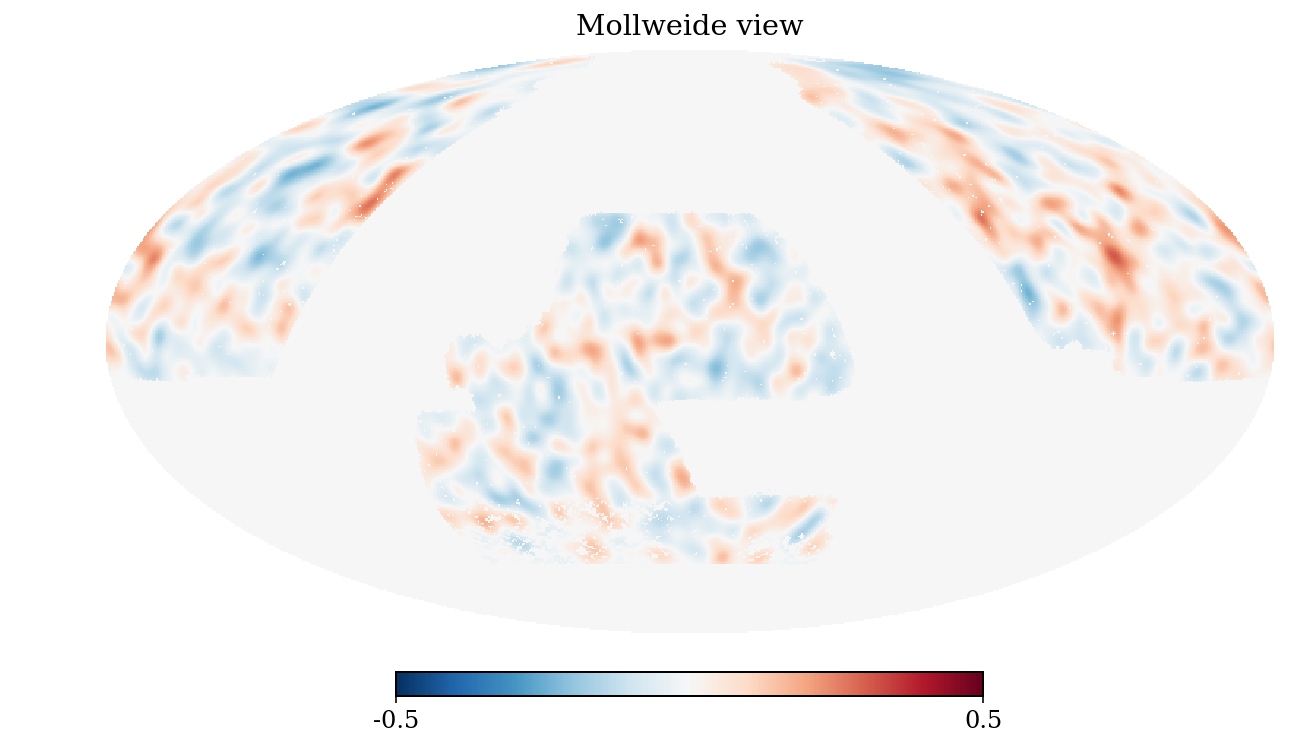

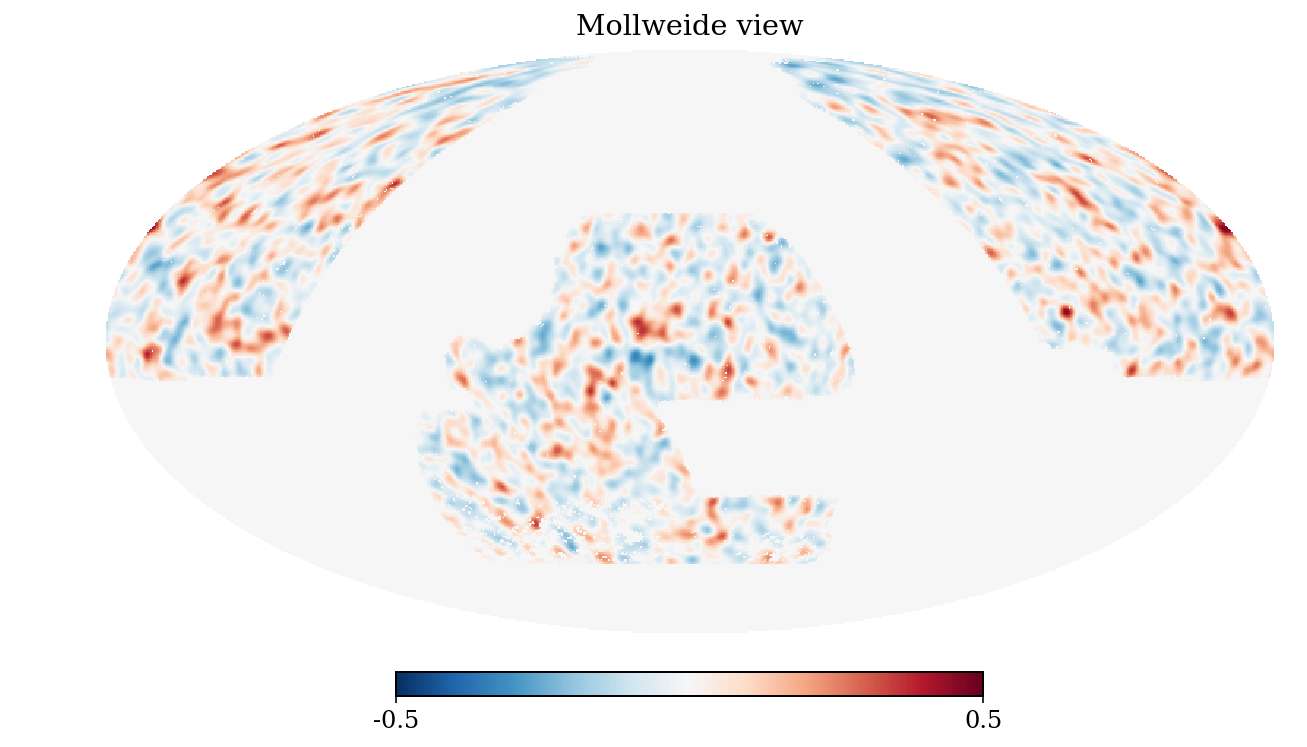

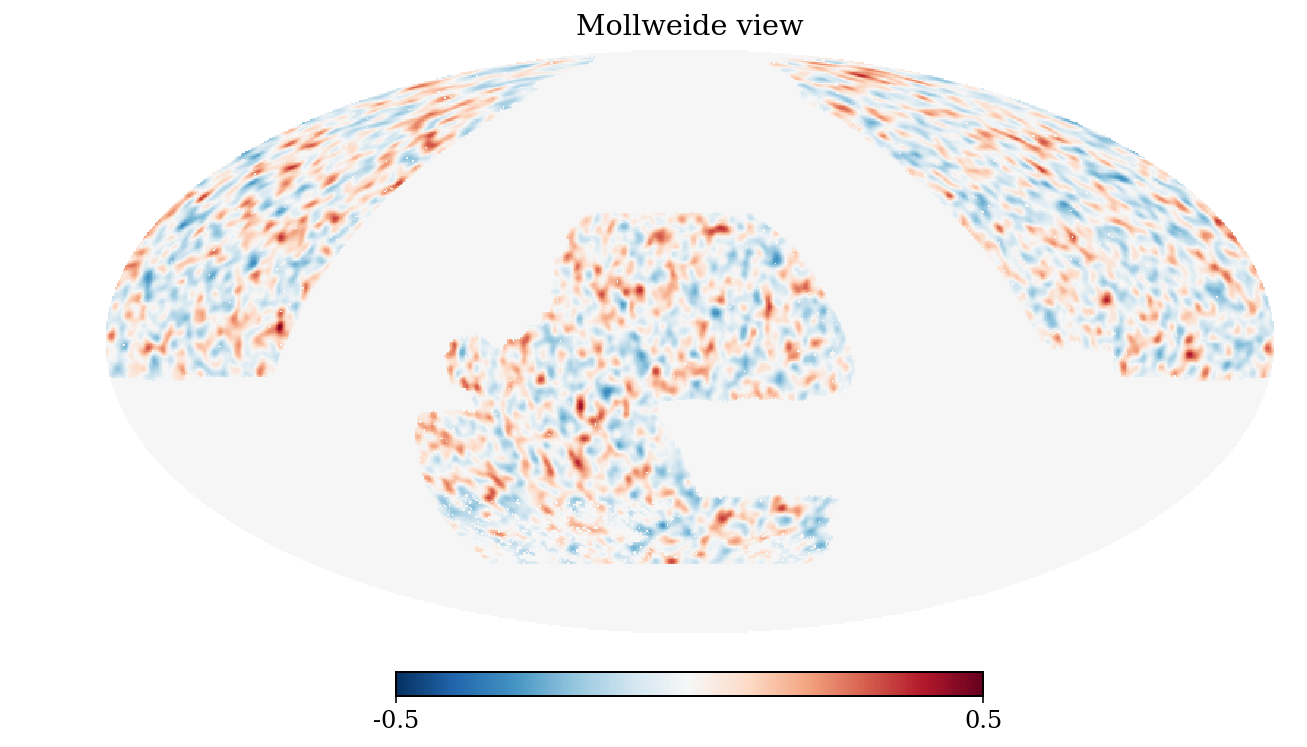

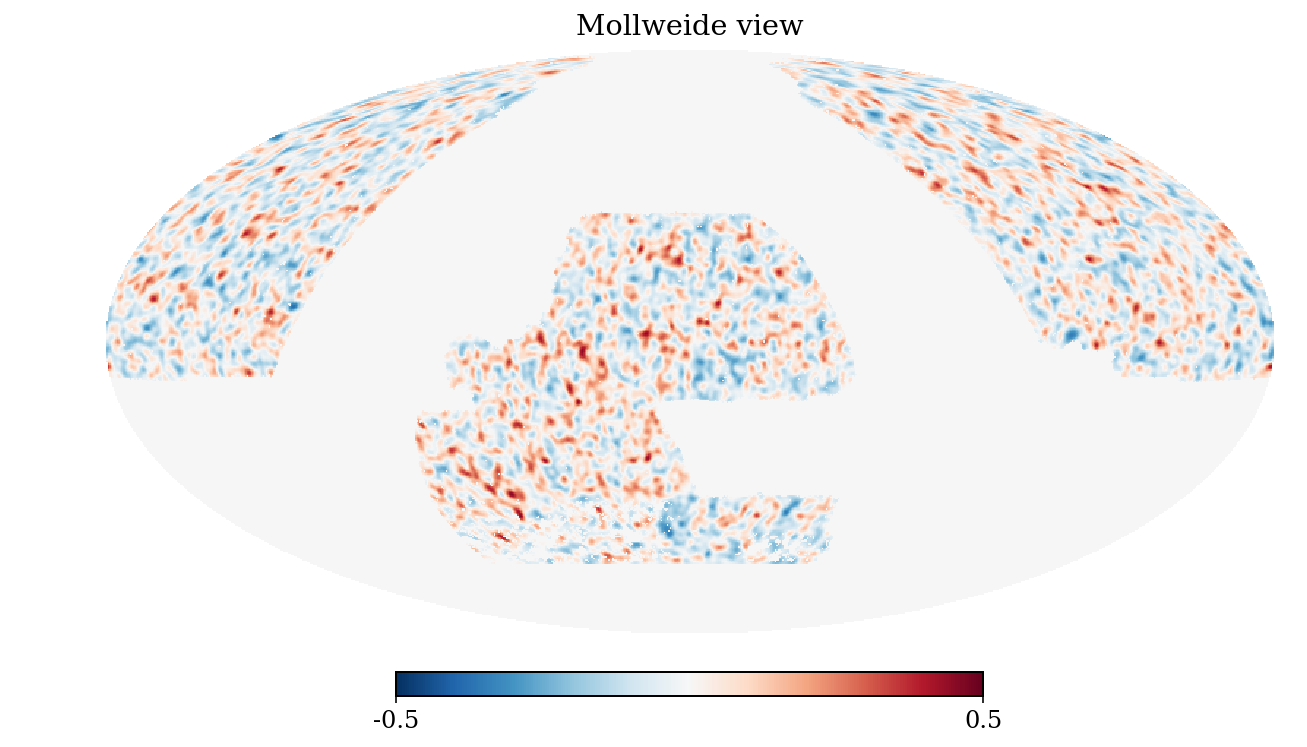

In [19]:
for ii in range(Nz):
    hp.mollview(densmap_smth[ii],max=0.5,min=-0.5,cmap='RdBu_r')
    pl.show()

[  7.90313770e-02  -7.26290260e-03   1.95074527e+04]
[  9.39102362e-02  -1.72901541e-02   1.92135777e+04]
[  9.55230690e-02  -1.53670822e-02   1.91675862e+04]
[  1.09203210e-01  -1.54338249e-02   1.95337825e+04]
[-0.11 -0.14 -0.14 -0.15]


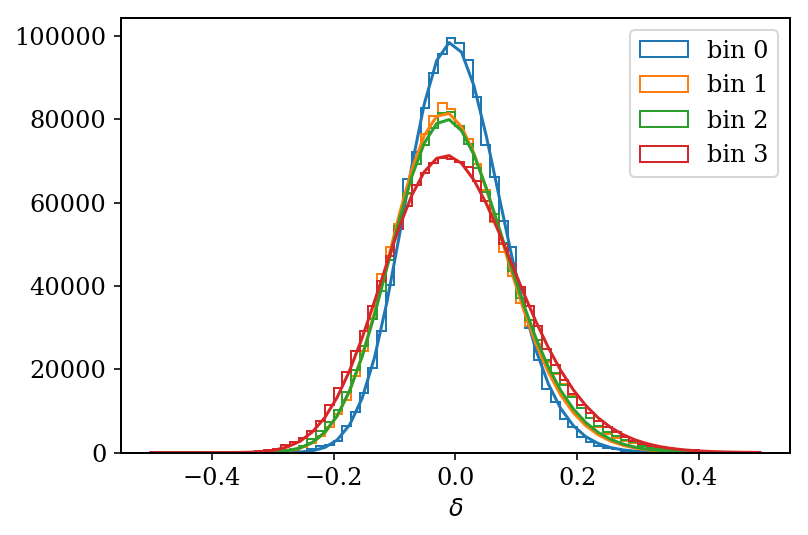

In [34]:
#look at the density distribution of each pixel
#fit by a simple lognormal
#determine the cut
delta_cut=np.zeros(Nz)
for ii in range(Nz):
    cc=pl.hist(densmap_smth[ii][mask.astype(bool)],bins=70,range=[-0.5,0.5],label='bin %s'%ii,histtype='step')
    ind=cc[0]>0
    x=((cc[1]+np.roll(cc[1],1))*0.5)[1:]
    x=x[ind]
    p0=[0.1,0,cc[0].max()]
    w=1/cc[0][ind]
    w=w/sum(w)
    yfit=cc[0][ind]
     
    res = minimize(fit_lognormal, p0, args=(x,yfit,w),method='Nelder-Mead', tol=1e-6)
    print(res.x)
    xsamp=np.linspace(-0.5,0.5,50)
    pl.plot(xsamp,Gaussian(np.log(xsamp+1),sig=res.x[0],x0=res.x[1])*res.x[2],color='C%d'%ii)
    
    #10 percent most underdens pixels (5 percent for clusters)
    ind=find_delta_c(cc[0], 0.1)
    x=((cc[1]+np.roll(cc[1],1))*0.5)[1:]
    delta_cut[ii]=x[ind]
pl.xlabel('$\\delta$')
pl.legend()
delta_cut=np.round(delta_cut,decimals=2)
print(delta_cut)

## Find voids

In [9]:
'''
This runs the void finder, which outputs the void catalogues in each redshift slice in directory [outdir].
The ralim, declim is applied to limit the area of the void finder search.
The r_bins is the increment in the radius for the search of R_v.
Use lab as a tag for the output files.
density_cut is used to define potential void centres.
degelim is used to exclude voids which are largely outside the mask. Set it to the lowest fraction inside the mask.

The output files gives info on the void centre and void radius:
[outdir].txt gives: pixel number of the centre, ra, dec, R_v (in radian) for each column
[outdir]-profile.txt gives: the mean density measured using r_bins on the smoothed density map

Note: for clusters, use density map * -1.
'''

ralim=[0,360]
declim=[-90,90]
r_bins=(np.linspace(1,300,150))
lab='voids'

for ii in range(Nz):
    outdir=datadir+'voids-smth-20/%s-zmin-%s-zmax-%s'%(lab,nzslice[ii],nzslice[ii+1])
    iswf.from_delta_to_voids(mask, densmap_smth[ii], ralim, declim, meanz[ii], r_bins, outdir, nside=nside, \
                             nest=False, density_cut=delta_cut[ii],edgelim=0.7)

## Void properties

In [29]:
voids={}
delta_c={}
voidr_cm={}
nvoids=np.zeros(Nz)
for ii in range(Nz):
    fname=datadir+'voids-smth-20/%s-zmin-%s-zmax-%s.txt'%(lab,nzslice[ii],nzslice[ii+1])
    voids[ii]=np.loadtxt(fname)
    voidr=voids[ii][:,3]
    fname=datadir+'voids-smth-20/%s-zmin-%s-zmax-%s-profile.txt'%(lab,nzslice[ii],nzslice[ii+1])
    profile=np.loadtxt(fname)
    delta_c[ii]=profile[0,1:]
    voidr_cm[ii]=voidr*meand_cm[ii]
    nvoids[ii]=len(voids[ii][:,1])
print('Number of voids: ',nvoids)

('Number of voids: ', array([  33.,  111.,  223.,  332.]))


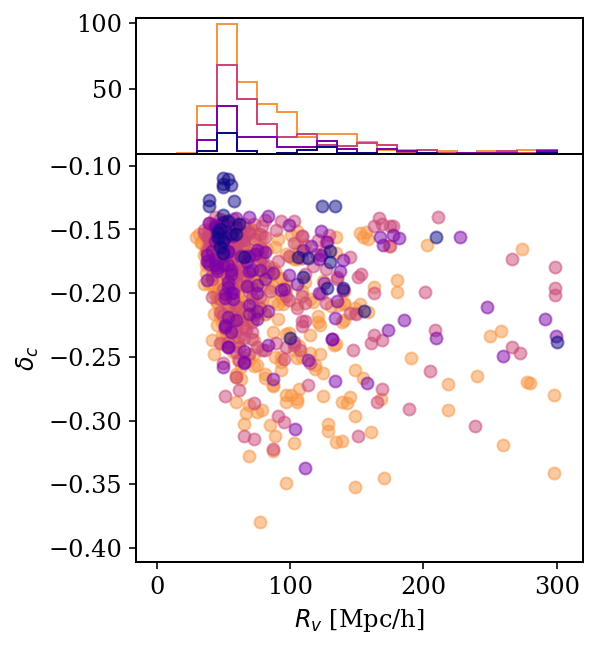

In [38]:
#Look at the void radius and central density
cmap = matplotlib.cm.get_cmap('plasma')
fig,axarr=pl.subplots(2,figsize=[4,5],sharex=True,gridspec_kw={'height_ratios': [1, 3]})
for ii in range(4):
    pl.sca(axarr[0])
    cc=pl.hist(voidr_cm[3-ii],histtype='step',bins=20,range=[0,300],label='bin %s'%(3-ii),color=cmap((3-ii)/4.))
    pl.yticks([50,100])
    pl.sca(axarr[1])
    pl.scatter(voidr_cm[3-ii],delta_c[3-ii],alpha=0.5,c=cmap((3-ii)/4.))
pl.ylabel('$\\delta_c$')
pl.xlabel('$R_v$ [Mpc/h]')
pl.subplots_adjust(hspace=0)

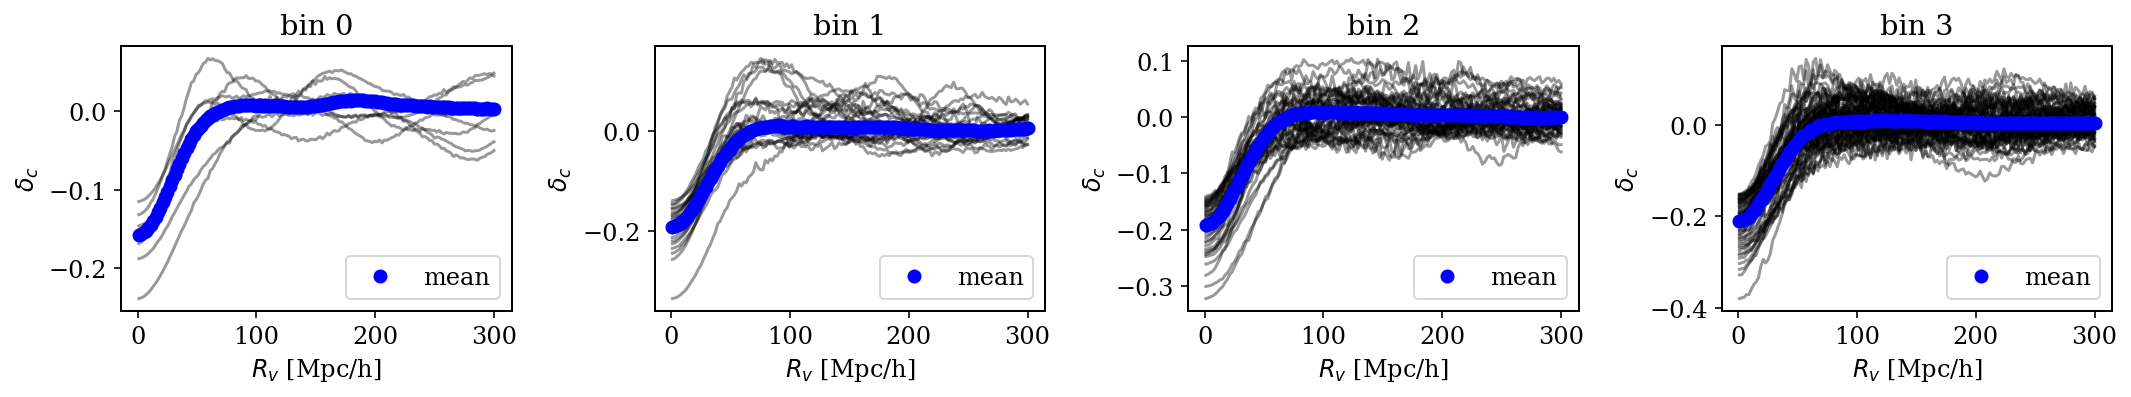

In [17]:
#Plot some of the void profiles as a function of comoving radius
fig,axarr=pl.subplots(1,4,figsize=[15,3])
mean_prof_list=[]
for ii in range(4):   
    pl.sca(axarr[ii])
    fname=datadir+'voids-smth-20/%s-zmin-%s-zmax-%s-profile.txt'%(lab,nzslice[ii],nzslice[ii+1])
    profile=np.loadtxt(fname)
    plot_prof=profile[:,1::5]
    mean_prof=np.mean(profile[:,1:],axis=1)
    for kk in range(len(plot_prof[0,:])):
        pl.plot(profile[:,0], plot_prof[:,kk],'k',alpha=0.4)
    pl.plot(profile[:,0],mean_prof,'bo',label='mean')
    pl.ylabel('$\\delta_c$')
    pl.xlabel('$R_v$ [Mpc/h]')
    mean_prof_list.append(mean_prof)
    pl.title('bin %d'%ii)
    pl.legend()
pl.tight_layout()

# Stacking the galaxy density
This uses the unsmoothed density map.

In [11]:
#This cell uses multiprocessor to process the stacking. The output is 8 pickle files which stores the rotated map
#and mask at the void positions.
#The setting of the output can be found in "operation_function": we use default setting
#with maxR=3*Rv with L=200 grids.

outdir=datadir+'voids-smth-20-stacking-Rv-scaled/'
for ii in range(0,4):
    print('working on bin %d...'%ii)
    dindex=nvoids[ii]/8+1
    dindex=int(dindex)
    
    raa=voids[ii][:,1]
    decc=voids[ii][:,2]
    voidrr=voids[ii][:,3]
    
    map_type='density'
    def this_worker(tupin):
        out=operation_function(densmap[ii],mask,tupin[0],tupin[1],tupin[2],
                               outfile=outdir+'%s-bin-%d-rot-run.%d.pkl'%(map_type,ii,tupin[3]))
        return 0

    #parallelization aspects
    nthread=8
    pool = mp.Pool(nthread)

    Nrot=len(raa)

    arglist=[]
    index_min=0;dindex=dindex;nindex=8
    count=0
    index_this_max=index_min
    for iind in range(0,nindex):
        index_this_min=index_this_max
        index_this_max=index_this_min+dindex
        count=count+1
        arglist.append((raa[index_this_min:index_this_max],decc[index_this_min:index_this_max],
                        voidrr[index_this_min:index_this_max],count))

    pool.map(this_worker, arglist)

    print('Finished!!')

pool.close()

working on bin 0...
working on dataslice!
working on dataslice!
working on dataslice!
working on dataslice!
working on dataslice!
working on dataslice!
working on dataslice!
working on dataslice!
('written impute ditionary:', '/disk2/qhang/ISW_CMB/LegacySurvey/pipeline/g24_r22_w119.5_common_dz0.05_3dinferzbin/voids/densmap-bin-0-rot-run.8.pkl')
('written impute ditionary:', '/disk2/qhang/ISW_CMB/LegacySurvey/pipeline/g24_r22_w119.5_common_dz0.05_3dinferzbin/voids/densmap-bin-0-rot-run.7.pkl')
('written impute ditionary:', '/disk2/qhang/ISW_CMB/LegacySurvey/pipeline/g24_r22_w119.5_common_dz0.05_3dinferzbin/voids/densmap-bin-0-rot-run.2.pkl')
('written impute ditionary:', '/disk2/qhang/ISW_CMB/LegacySurvey/pipeline/g24_r22_w119.5_common_dz0.05_3dinferzbin/voids/densmap-bin-0-rot-run.4.pkl')
('written impute ditionary:', '/disk2/qhang/ISW_CMB/LegacySurvey/pipeline/g24_r22_w119.5_common_dz0.05_3dinferzbin/voids/densmap-bin-0-rot-run.3.pkl')
('written impute ditionary:', '/disk2/qhang/ISW_C

In [ ]:
#Combine the data and save them
#Choose rad_deg_scaled in range [0,maxR] for the stacked profile. These are the binedges.
#Here we also compute the Jackknife covariance for the void sample

rad_deg_scaled=np.linspace(0,3,16)
scaled_stack2d={}
scaled_profile={}
scaled_covariance={}
for ii in range(4):
    outdir=datadir+'voids-smth-20-stacking-Rv-scaled/'
    dataholder_map, dataholder_mask =iswf.read_rotmaps(outdir,zbin=ii,map_type=map_type,index=False)
    
    stacked=iswf.stack_map(dataholder_map, dataholder_mask, stack_all=True,stack_index=None)
    Values=stacked.reshape(L,L)
    Values=np.fliplr(Values)
    scaled_stack2d[ii]=Values
    
    radx,profile_out,covariance_out=iswf.jackknife_error_stack_scaled(dataholder_map, dataholder_mask, rad_deg_scaled, L=200,maxR=3.)
    scaled_profile[ii]=profile_out
    scaled_covariance[ii]=covariance_out
    
    #everything combined
    if ii==0:
        DH_MAP=dataholder_map
        DH_MASK=dataholder_mask
    if ii>0:
        DH_MAP=np.column_stack((DH_MAP,dataholder_map))
        DH_MASK=np.column_stack((DH_MASK,dataholder_mask)) 
        
    stacked=iswf.stack_map(DH_MAP, DH_MASK, stack_all=True,stack_index=None)
    Values=stacked.reshape(L,L)
    Values=np.fliplr(Values)
    scaled_stack2d_all=Values

    radx,profile_out,covariance_out=iswf.jackknife_error_stack_scaled(DH_MAP, DH_MASK, rad_deg_scaled, L=200,maxR=3.)
    scaled_profile_all=profile_out
    scaled_covariance_all=covariance_out
    
#save
if(1):
    out=[radx,scaled_stack2d,scaled_profile,scaled_covariance]
    iswf.dump_save(out,outdir+'%s_scaled_stack-2d-jkprof-cov.pkl'%map_type)
    
    out=[radx,scaled_stack2d_all,scaled_profile_all,scaled_covariance_all]
    iswf.dump_save(out,outdir+'%s_scaled_stack-all_voids-2d-jkprof-cov.pkl'%map_type)

In [19]:
#You can directly load these files here if you have already computed the above

outdir=datadir+'voids-smth-20-stacking-Rv-scaled/density_scaled_stack-2d-jkprof-cov.pkl'
fin=iswf.dump_load(outdir)
radx=fin[0]
scaled_stack2d=fin[1]
scaled_profile=fin[2]
scaled_covariance=fin[3]

outdir=datadir+'voids-smth-20-stacking-Rv-scaled/density_scaled_stack-all_voids-2d-jkprof-cov.pkl'
fin=iswf.dump_load(outdir)
scaled_stack2d_all=fin[1]
scaled_profile_all=fin[2]
scaled_covariance_all=fin[3]

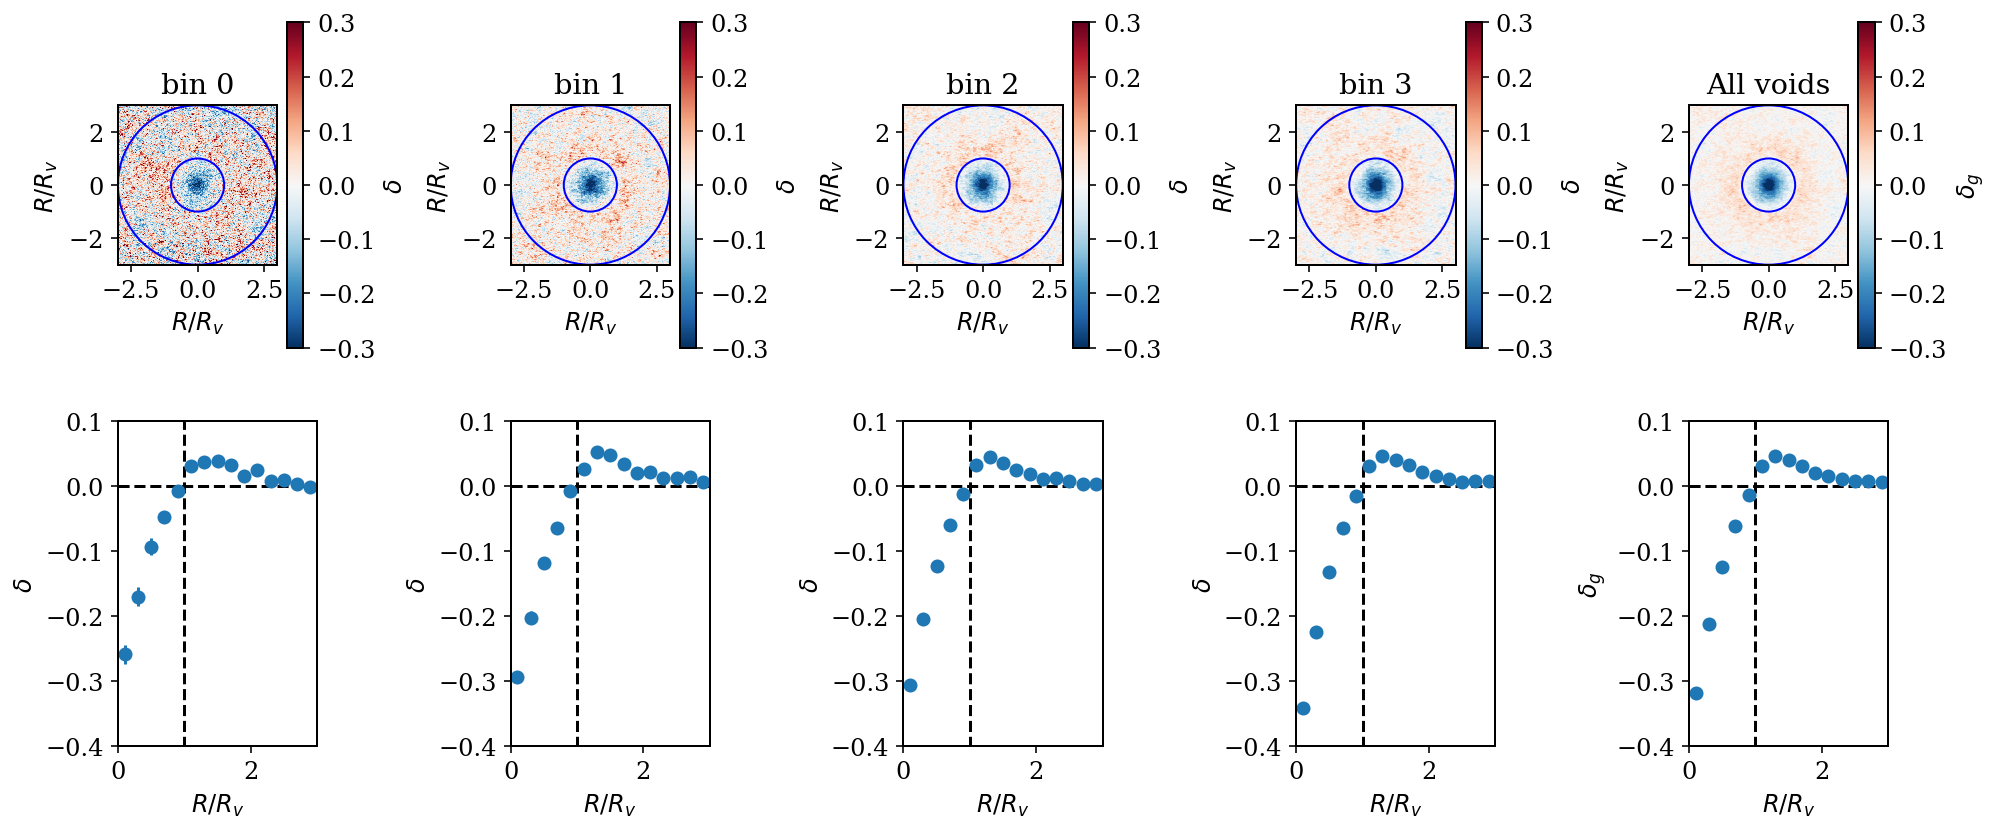

In [32]:
fig,axarr=pl.subplots(2,5,figsize=[14,6])
maxR=3
for ii in range(4):
    pl.sca(axarr[0,ii])
    pl.imshow(scaled_stack2d[ii],origin='lower',cmap='RdBu_r',extent=[-maxR,maxR,-maxR,maxR],
                      vmax=0.3,vmin=-0.3)
    pl.colorbar(label='$\\delta$')
    circle = pl.Circle((0, 0), 1, color='b', fill=False)
    circle2 = pl.Circle((0, 0), 3, color='b', fill=False)
    ax = pl.gca()
    ax.add_patch(circle)
    ax.add_patch(circle2)
    pl.xlabel('$R/R_v$')
    pl.ylabel('$R/R_v$')
    pl.title('bin %d'%ii)

    pl.sca(axarr[1,ii])
    njn=nvoids[ii]
    pl.errorbar(radx,scaled_profile[ii][:,0],scaled_profile[ii][:,1]*np.sqrt(njn-1),fmt='o')
    pl.plot([0,3],[0,0],'k--')
    pl.xlim([0,3])
    pl.ylim([-0.4,0.1])
    pl.xlabel('$R/R_v$')
    pl.ylabel('$\\delta$')
    pl.plot([1,1],[-0.5,0.1],'k--')

pl.sca(axarr[0,4])
pl.imshow(scaled_stack2d_all,origin='lower',cmap='RdBu_r',extent=[-maxR,maxR,-maxR,maxR],
                  vmax=0.3,vmin=-0.3)
pl.colorbar(label='$\\delta_g$')
circle = pl.Circle((0, 0), 1, color='b', fill=False)
circle2 = pl.Circle((0, 0), 3, color='b', fill=False)
ax = pl.gca()
ax.add_patch(circle)
ax.add_patch(circle2)
pl.xlabel('$R/R_v$')
pl.ylabel('$R/R_v$')
pl.title('All voids')

pl.sca(axarr[1,4])
njn=sum(nvoids)
pl.errorbar(radx,scaled_profile_all[:,0],scaled_profile_all[:,1]*np.sqrt(njn-1),fmt='o',
           label='')
pl.plot([0,3],[0,0],'k--')
pl.plot([1,1],[-0.5,0.1],'k--')
pl.xlim([0,3])
pl.ylim([-0.4,0.1])
pl.xlabel('$R/R_v$')
pl.ylabel('$\\delta_g$')

pl.tight_layout()

Text(0.5,1,u'All voids')

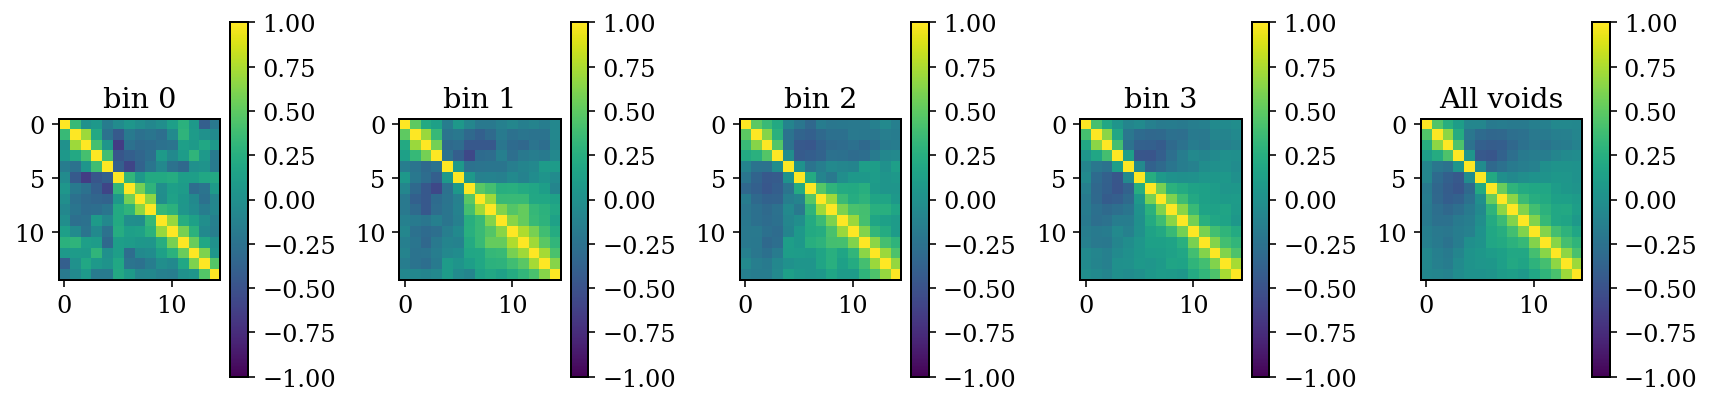

In [41]:
#Jackknife correlation matrix
fig,axarr=pl.subplots(1,5,figsize=[12,3])
for ii in range(4):
    pl.sca(axarr[ii])
    corr=uf.corr_mat(scaled_covariance[ii])
    im=pl.imshow(corr,vmax=1,vmin=-1)
    pl.colorbar(im)
    pl.title('bin %d'%ii)
pl.sca(axarr[4])
corr=uf.corr_mat(scaled_covariance_all)
im=pl.imshow(corr,vmax=1,vmin=-1)
pl.colorbar(im)
pl.tight_layout()
pl.title('All voids')

# Stacking the lensing convergence

In [47]:
##load the kappa map and kappa mask
kappamap=hp.read_map('../data/Planck18/planck2018-ellmax2048_lensmap_512_equatorial_alm.fits')
kappamask=hp.read_map('../data/Planck18/planck2018-ellmax2048_lensmask_512_equatorial.fits')

#smooth kappa by fwhm=1 degrees
kappasmth=hp.sphtfunc.smoothing(kappamap*kappamask,fwhm=1*np.pi/180.)
kappasmth=kappasmth*kappamask

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [ ]:
outdir=datadir+'voids-smth-20-stacking-Rv-scaled/'
for ii in range(0,4):
    print('working on bin %d...'%ii)
    dindex=nvoids[ii]/8+1
    dindex=int(dindex)
    
    raa=voids[ii][:,1]
    decc=voids[ii][:,2]
    voidrr=voids[ii][:,3]
    
    map_type='kappa'
    def this_worker(tupin):
        out=operation_function(kappasmth,kappamask,tupin[0],tupin[1],tupin[2],
                               outfile=outdir+'%s-bin-%d-rot-run.%d.pkl'%(map_type,ii,tupin[3]))
        return 0

    #parallelization aspects
    nthread=8
    pool = mp.Pool(nthread)

    Nrot=len(raa)

    arglist=[]
    index_min=0;dindex=dindex;nindex=8
    count=0
    index_this_max=index_min
    for iind in range(0,nindex):
        index_this_min=index_this_max
        index_this_max=index_this_min+dindex
        count=count+1
        arglist.append((raa[index_this_min:index_this_max],decc[index_this_min:index_this_max],
                        voidrr[index_this_min:index_this_max],count))

    pool.map(this_worker, arglist)

    print('Finished!!')

pool.close()

In [ ]:
#Combine the data and save them
#Choose rad_deg_scaled in range [0,maxR] for the stacked profile. These are the binedges.
#Here we also compute the Jackknife covariance for the void sample

rad_deg_scaled=np.linspace(0,3,16)
scaled_stack2d={}
scaled_profile={}
scaled_covariance={}
for ii in range(4):
    outdir=datadir+'voids-smth-20-stacking-Rv-scaled/'
    dataholder_map, dataholder_mask =iswf.read_rotmaps(outdir,zbin=ii,map_type=map_type,index=False)
    
    stacked=iswf.stack_map(dataholder_map, dataholder_mask, stack_all=True,stack_index=None)
    Values=stacked.reshape(L,L)
    Values=np.fliplr(Values)
    scaled_stack2d[ii]=Values
    
    radx,profile_out,covariance_out=iswf.jackknife_error_stack_scaled(dataholder_map, dataholder_mask, rad_deg_scaled, L=200,maxR=3.)
    scaled_profile[ii]=profile_out
    scaled_covariance[ii]=covariance_out
    
    #everything combined
    if ii==0:
        DH_MAP=dataholder_map
        DH_MASK=dataholder_mask
    if ii>0:
        DH_MAP=np.column_stack((DH_MAP,dataholder_map))
        DH_MASK=np.column_stack((DH_MASK,dataholder_mask)) 
        
    stacked=iswf.stack_map(DH_MAP, DH_MASK, stack_all=True,stack_index=None)
    Values=stacked.reshape(L,L)
    Values=np.fliplr(Values)
    scaled_stack2d_all=Values

    radx,profile_out,covariance_out=iswf.jackknife_error_stack_scaled(DH_MAP, DH_MASK, rad_deg_scaled, L=200,maxR=3.)
    scaled_profile_all=profile_out
    scaled_covariance_all=covariance_out
    
#save
if(1):
    out=[radx,scaled_stack2d,scaled_profile,scaled_covariance]
    iswf.dump_save(out,outdir+'%s_scaled_stack-2d-jkprof-cov.pkl'%map_type)
    
    out=[radx,scaled_stack2d_all,scaled_profile_all,scaled_covariance_all]
    iswf.dump_save(out,outdir+'%s_scaled_stack-all_voids-2d-jkprof-cov.pkl'%map_type)

In [44]:
#You can directly load these files here if you have already computed the above

outdir=usedir+'voids-smth-20-stacking-Rv-scaled/kappa_scaled_stack-2d-jkprof-cov.pkl'
fin=iswf.dump_load(outdir)
radx=fin[0]
scaled_stack2d=fin[1]
scaled_profile=fin[2]
scaled_covariance=fin[3]

outdir=usedir+'voids-smth-20-stacking-Rv-scaled/kappa_scaled_stack-all_voids-2d-jkprof-cov.pkl'
fin=iswf.dump_load(outdir)
scaled_stack2d_all=fin[1]
scaled_profile_all=fin[2]
scaled_covariance_all=fin[3]

#radx=((rad_deg_scaled+np.roll(rad_deg_scaled,1))*0.5)[1:]

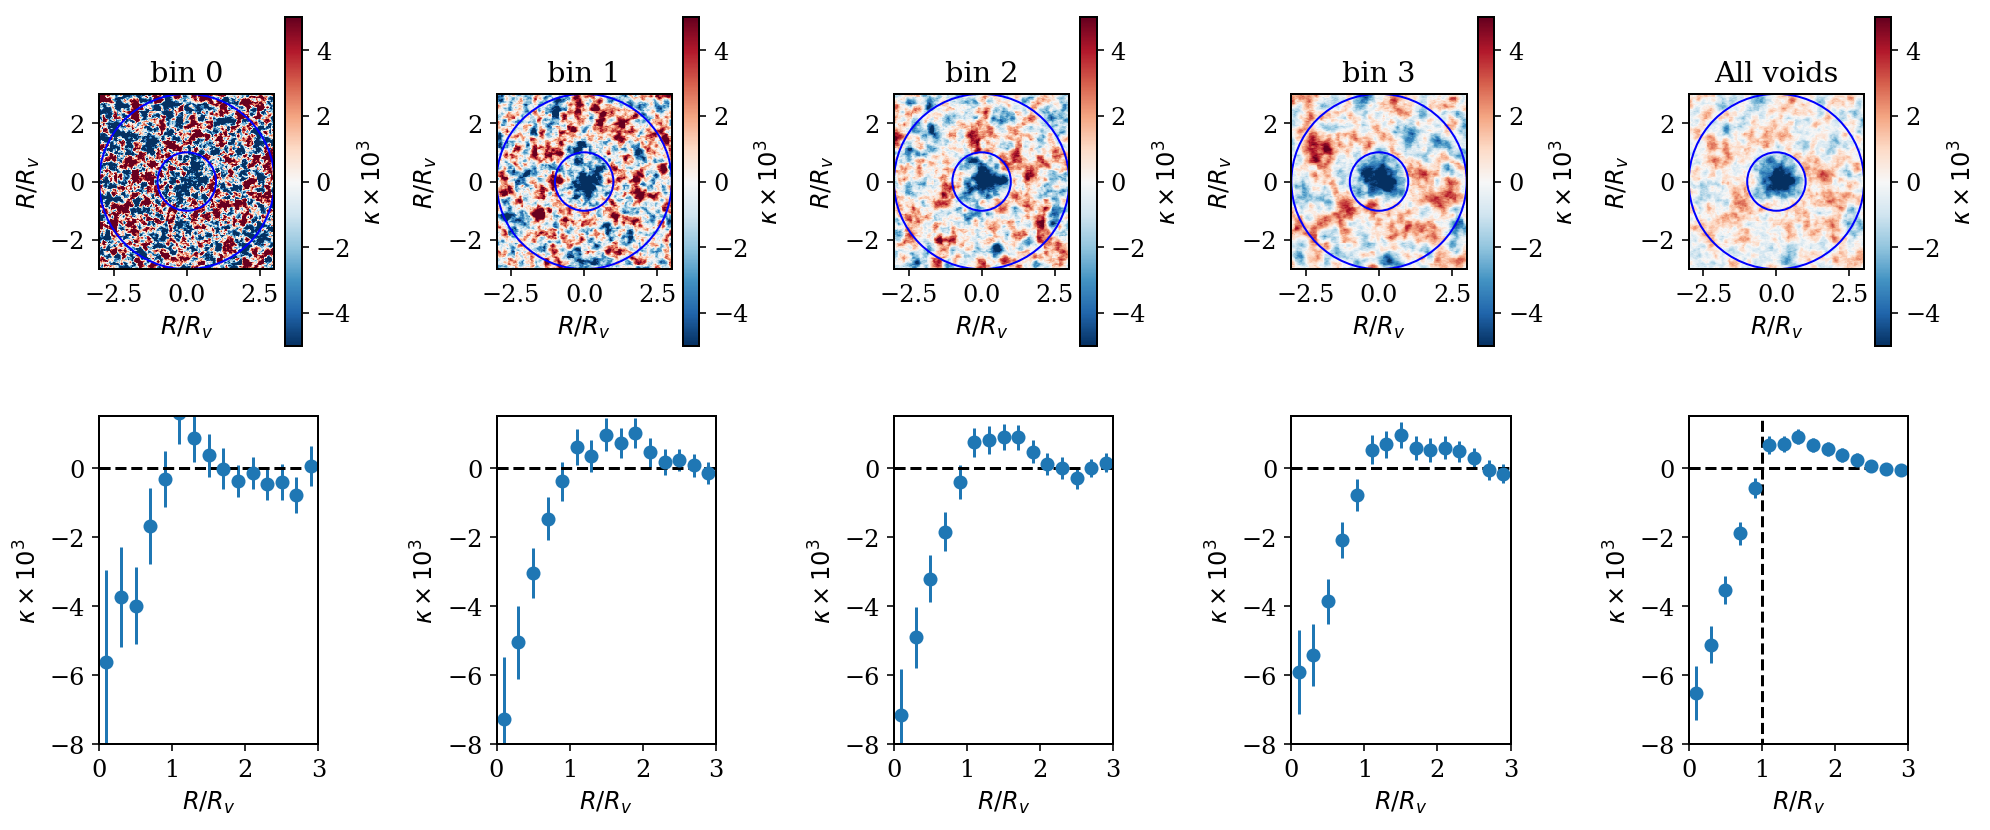

In [53]:
fig,axarr=pl.subplots(2,5,figsize=[14,6])
for ii in range(4):
    pl.sca(axarr[0,ii])
    pl.imshow(scaled_stack2d[ii]*1e3,origin='lower',cmap='RdBu_r',extent=[-maxR,maxR,-maxR,maxR],
                      vmax=5,vmin=-5)
    pl.colorbar(label='$\\kappa\\times10^3$')
    circle = pl.Circle((0, 0), 1, color='b', fill=False)
    circle2 = pl.Circle((0, 0), 3, color='b', fill=False)
    ax = pl.gca()
    ax.add_patch(circle)
    ax.add_patch(circle2)
    pl.xlabel('$R/R_v$')
    pl.ylabel('$R/R_v$')
    pl.title('bin %d'%ii)

    pl.sca(axarr[1,ii])
    njn=nvoids[ii]
    pl.errorbar(radx,scaled_profile[ii][:,0]*1e3,scaled_profile[ii][:,1]*np.sqrt(njn-1)*1e3,fmt='o')
    pl.plot([0,3],[0,0],'k--')
    pl.xlim([0,3])
    pl.ylim([-8,1.5])
    pl.xlabel('$R/R_v$')
    pl.ylabel('$\\kappa\\times10^3$')

pl.sca(axarr[0,4])
pl.imshow(scaled_stack2d_all*1e3,origin='lower',cmap='RdBu_r',extent=[-maxR,maxR,-maxR,maxR],
                  vmax=5,vmin=-5)
pl.colorbar(label='$\\kappa\\times10^3$')
circle = pl.Circle((0, 0), 1, color='b', fill=False)
circle2 = pl.Circle((0, 0), 3, color='b', fill=False)
ax = pl.gca()
ax.add_patch(circle)
ax.add_patch(circle2)
pl.xlabel('$R/R_v$')
pl.ylabel('$R/R_v$')
pl.title('All voids')

pl.sca(axarr[1,4])
njn=sum(nvoids)
pl.errorbar(radx,scaled_profile_all[:,0]*1e3,scaled_profile_all[:,1]*1e3*np.sqrt(njn-1),fmt='o',
           label='')
pl.plot([0,3],[0,0],'k--')
pl.plot([1,1],[-10,1.5],'k--')
pl.xlim([0,3])
pl.ylim([-8,1.5])
pl.xlabel('$R/R_v$')
pl.ylabel('$\\kappa\\times10^3$')

pl.tight_layout()

Text(0.5,1,u'All voids')

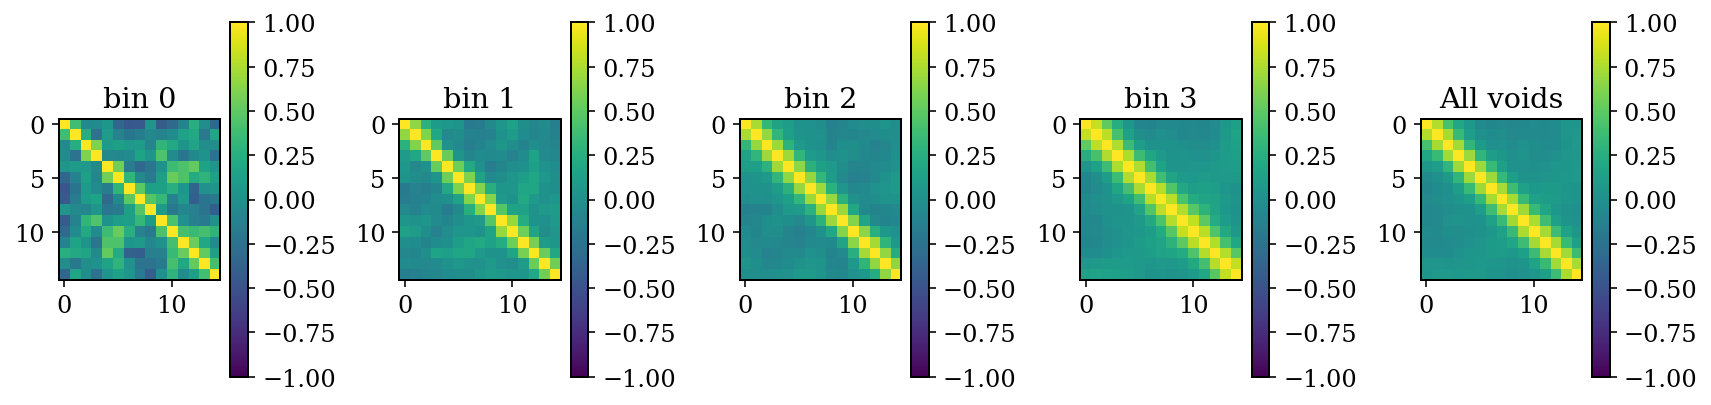

In [54]:
#Jackknife correlation matrix
fig,axarr=pl.subplots(1,5,figsize=[12,3])
for ii in range(4):
    pl.sca(axarr[ii])
    corr=uf.corr_mat(scaled_covariance[ii])
    im=pl.imshow(corr,vmax=1,vmin=-1)
    pl.colorbar(im)
    pl.title('bin %d'%ii)
pl.sca(axarr[4])
corr=uf.corr_mat(scaled_covariance_all)
im=pl.imshow(corr,vmax=1,vmin=-1)
pl.colorbar(im)
pl.tight_layout()
pl.title('All voids')

# Stacking the CMB temperature

In [ ]:
##load the ISW map and kappa mask
#add them together
iswmap=hp.read_map('../data/Planck18/planck2018_tmap_512_equatorial_alm.fits')

cmbt_mask=hp.read_map('../data/Planck18/planck2018_tmask_512_equatorial.fits')

iswmap=iswmap*cmbt_mask

fsky=sum(cmbt_mask)/float(len(cmbt_mask))

#remove ell<10
lmin=10
nside=512
lmax=nside*3
fl=np.ones(lmax+1)
fl[:lmin]=0
alm=hp.map2alm(iswmap,lmax=lmax)
alm_cut=hp.almxfl(alm,fl)
mapout=hp.alm2map(alm_cut,nside)
iswmap_l10=mapout*cmbt_mask

In [ ]:
outdir=datadir+'voids-smth-20-stacking-Rv-scaled/'
for ii in range(0,4):
    print('working on bin %d...'%ii)
    dindex=nvoids[ii]/8+1
    dindex=int(dindex)
    
    raa=voids[ii][:,1]
    decc=voids[ii][:,2]
    voidrr=voids[ii][:,3]
    
    map_type='isw'
    def this_worker(tupin):
        out=operation_function(iswmap_l10,cmbt_mask,tupin[0],tupin[1],tupin[2],
                               outfile=outdir+'%s-bin-%d-rot-run.%d.pkl'%(map_type,ii,tupin[3]))
        return 0

    #parallelization aspects
    nthread=8
    pool = mp.Pool(nthread)

    Nrot=len(raa)

    arglist=[]
    index_min=0;dindex=dindex;nindex=8
    count=0
    index_this_max=index_min
    for iind in range(0,nindex):
        index_this_min=index_this_max
        index_this_max=index_this_min+dindex
        count=count+1
        arglist.append((raa[index_this_min:index_this_max],decc[index_this_min:index_this_max],
                        voidrr[index_this_min:index_this_max],count))

    pool.map(this_worker, arglist)

    print('Finished!!')

pool.close()

In [ ]:
#Combine the data and save them
#Choose rad_deg_scaled in range [0,maxR] for the stacked profile. These are the binedges.
#Here we also compute the Jackknife covariance for the void sample

rad_deg_scaled=np.linspace(0,3,16)
scaled_stack2d={}
scaled_profile={}
scaled_covariance={}
for ii in range(4):
    outdir=datadir+'voids-smth-20-stacking-Rv-scaled/'
    dataholder_map, dataholder_mask =iswf.read_rotmaps(outdir,zbin=ii,map_type=map_type,index=False)
    
    stacked=iswf.stack_map(dataholder_map, dataholder_mask, stack_all=True,stack_index=None)
    Values=stacked.reshape(L,L)
    Values=np.fliplr(Values)
    scaled_stack2d[ii]=Values
    
    radx,profile_out,covariance_out=iswf.jackknife_error_stack_scaled(dataholder_map, dataholder_mask, rad_deg_scaled, L=200,maxR=3.)
    scaled_profile[ii]=profile_out
    scaled_covariance[ii]=covariance_out
    
    #everything combined
    if ii==0:
        DH_MAP=dataholder_map
        DH_MASK=dataholder_mask
    if ii>0:
        DH_MAP=np.column_stack((DH_MAP,dataholder_map))
        DH_MASK=np.column_stack((DH_MASK,dataholder_mask)) 
        
    stacked=iswf.stack_map(DH_MAP, DH_MASK, stack_all=True,stack_index=None)
    Values=stacked.reshape(L,L)
    Values=np.fliplr(Values)
    scaled_stack2d_all=Values

    radx,profile_out,covariance_out=iswf.jackknife_error_stack_scaled(DH_MAP, DH_MASK, rad_deg_scaled, L=200,maxR=3.)
    scaled_profile_all=profile_out
    scaled_covariance_all=covariance_out
    
#save
if(1):
    out=[radx,scaled_stack2d,scaled_profile,scaled_covariance]
    iswf.dump_save(out,outdir+'%s_scaled_stack-2d-jkprof-cov.pkl'%map_type)
    
    out=[radx,scaled_stack2d_all,scaled_profile_all,scaled_covariance_all]
    iswf.dump_save(out,outdir+'%s_scaled_stack-all_voids-2d-jkprof-cov.pkl'%map_type)

In [55]:
#You can directly load these files here if you have already computed the above

outdir=usedir+'voids-smth-20-stacking-Rv-scaled/isw_scaled_stack-2d-jkprof-cov.pkl'
fin=iswf.dump_load(outdir)
radx=fin[0]
scaled_stack2d=fin[1]
scaled_profile=fin[2]
scaled_covariance=fin[3]

outdir=usedir+'voids-smth-20-stacking-Rv-scaled/isw_scaled_stack-all_voids-2d-jkprof-cov.pkl'
fin=iswf.dump_load(outdir)
scaled_stack2d_all=fin[1]
scaled_profile_all=fin[2]
scaled_covariance_all=fin[3]

#radx=((rad_deg_scaled+np.roll(rad_deg_scaled,1))*0.5)[1:]

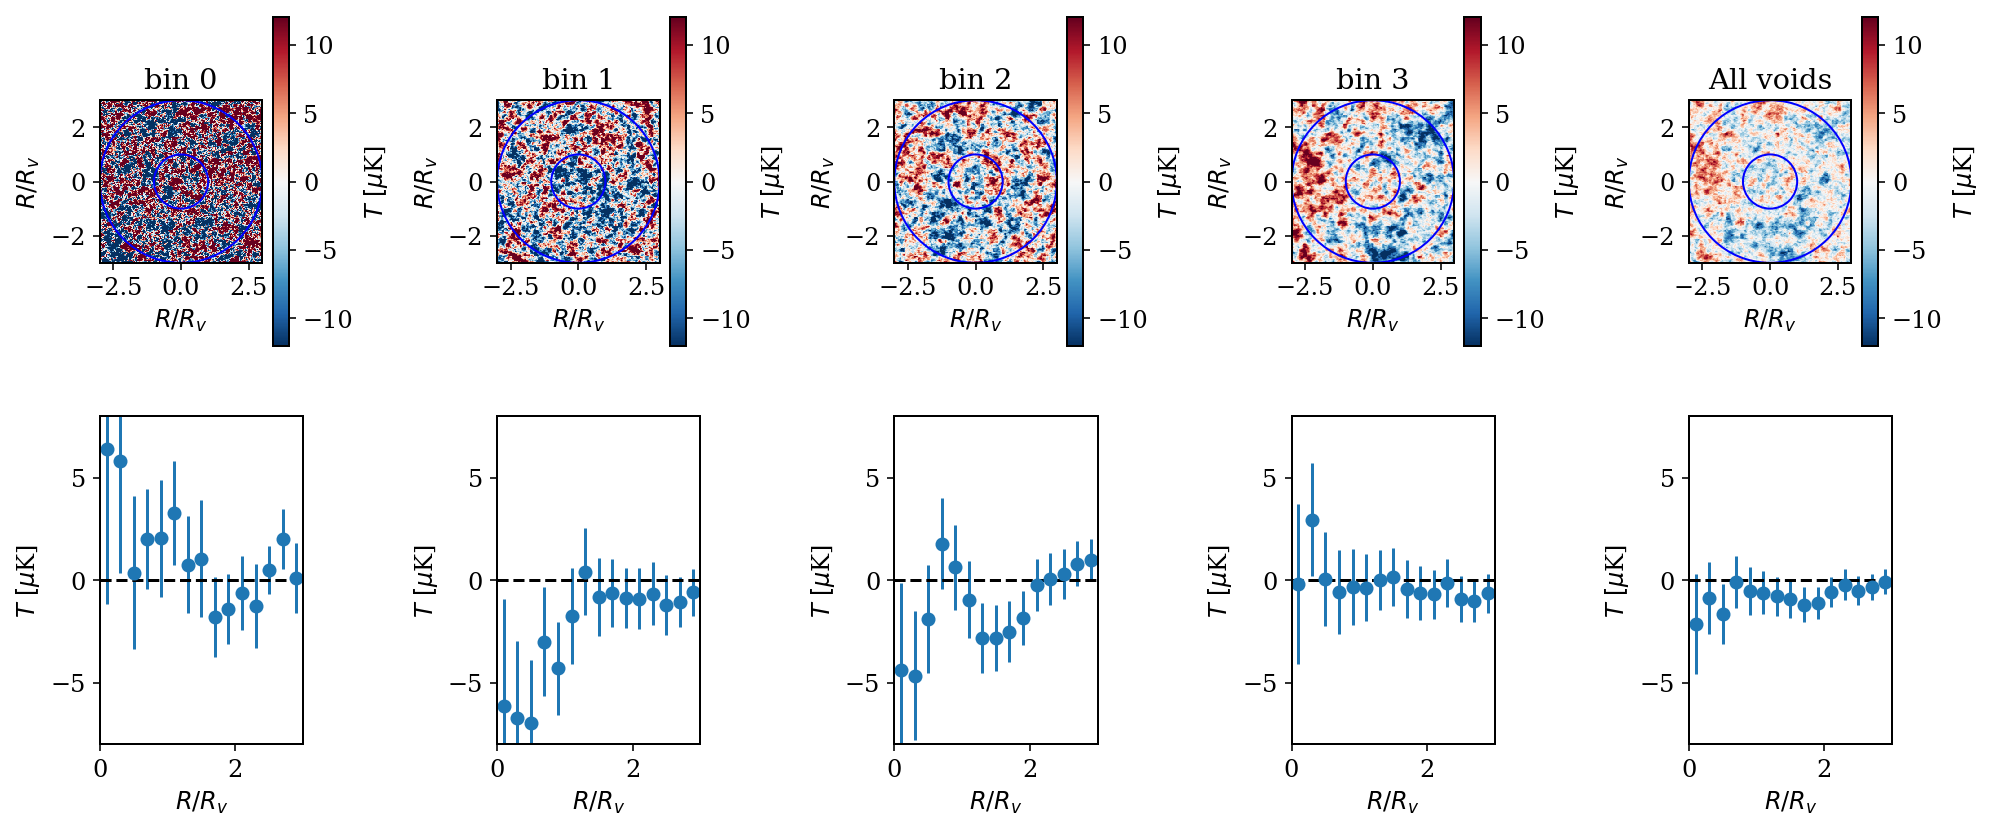

In [60]:
fig,axarr=pl.subplots(2,5,figsize=[14,6])
for ii in range(4):
    pl.sca(axarr[0,ii])
    pl.imshow(scaled_stack2d[ii]*1e6,origin='lower',cmap='RdBu_r',extent=[-maxR,maxR,-maxR,maxR],
                      vmax=12,vmin=-12)
    pl.colorbar(label='$T$ $[\\mu$K]')
    circle = pl.Circle((0, 0), 1, color='b', fill=False)
    circle2 = pl.Circle((0, 0), 3, color='b', fill=False)
    ax = pl.gca()
    ax.add_patch(circle)
    ax.add_patch(circle2)
    pl.xlabel('$R/R_v$')
    pl.ylabel('$R/R_v$')
    pl.title('bin %d'%ii)

    pl.sca(axarr[1,ii])
    njn=nvoids[ii]
    pl.errorbar(radx,scaled_profile[ii][:,0]*1e6,scaled_profile[ii][:,1]*np.sqrt(njn-1)*1e6,fmt='o',
               label='Legacy Survey')
    pl.plot([0,3],[0,0],'k--')
    pl.xlim([0,3])
    pl.ylim([-8,8])
    pl.xlabel('$R/R_v$')
    pl.ylabel('$T$ $[\\mu$K]')
    
pl.sca(axarr[0,4])
pl.imshow(scaled_stack2d_all*1e6,origin='lower',cmap='RdBu_r',extent=[-maxR,maxR,-maxR,maxR],
                  vmax=12,vmin=-12)
pl.colorbar(label='$T$ $[\\mu$K]')
circle = pl.Circle((0, 0), 1, color='b', fill=False)
circle2 = pl.Circle((0, 0), 3, color='b', fill=False)
ax = pl.gca()
ax.add_patch(circle)
ax.add_patch(circle2)
pl.xlabel('$R/R_v$')
pl.ylabel('$R/R_v$')
pl.title('All voids')

pl.sca(axarr[1,4])
njn=sum(nvoids)
pl.errorbar(radx,scaled_profile_all[:,0]*1e6,scaled_profile_all[:,1]*np.sqrt(njn-1)*1e6,fmt='o',
           label='Legacy Survey')
pl.plot([0,3],[0,0],'k--')
pl.xlim([0,3])
pl.ylim([-8,8])
pl.xlabel('$R/R_v$')
pl.ylabel('$T$ $[\\mu$K]')    
    
pl.tight_layout()

Text(0.5,1,u'All voids')

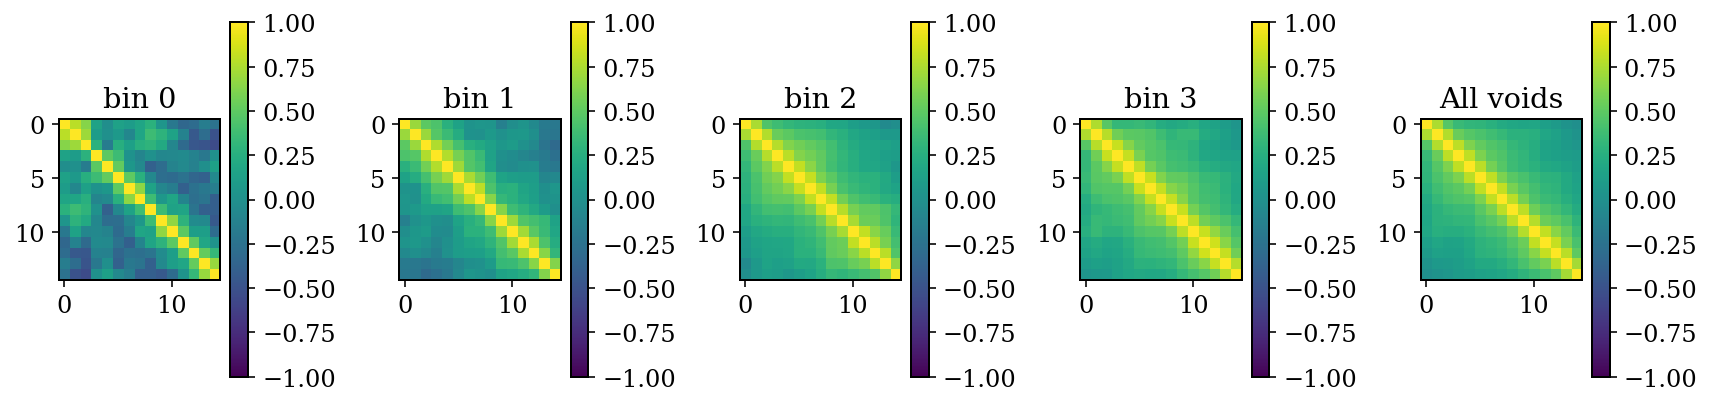

In [61]:
#Jackknife correlation matrix
fig,axarr=pl.subplots(1,5,figsize=[12,3])
for ii in range(4):
    pl.sca(axarr[ii])
    corr=uf.corr_mat(scaled_covariance[ii])
    im=pl.imshow(corr,vmax=1,vmin=-1)
    pl.colorbar(im)
    pl.title('bin %d'%ii)
pl.sca(axarr[4])
corr=uf.corr_mat(scaled_covariance_all)
im=pl.imshow(corr,vmax=1,vmin=-1)
pl.colorbar(im)
pl.tight_layout()
pl.title('All voids')